# Dataset Yeast

## Übersicht


## Imports

In [1]:
import os
import sys
import shutil

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

## Globals

In [2]:
ORGANISM = "yeast"
TAX_ID = 559292
LOG_FILE = f"../logs/{ORGANISM}_amino_sugar.log"
N_THREADS = 16
IDENTITY_THRESHOLD=70
OUTLIERS = "TODO"

## 1. Creating the dataset

### Filtering (Keywords, Organismus)

Keep the multi-substrate transporters for now, to analyze tem

In [3]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, 'w'):
        pass

create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [TAX_ID],
    output_tsv = f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta = f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log = LOG_FILE,
)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
Q08986,Amino-acid transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,SAM3 YPL274W,S-adenosylmethionine permease SAM3 (S-adenosyl...,2.A.3.10.15,559292,MDILKRGNESDKFTKIETESTTIPNDSDRSGSLIRRMKDSFKQSNL...
P38967,Amino-acid transport,Membrane;Transmembrane,Transport,TAT2 LTG3 SAB2 SCM2 TAP2 YOL020W,Tryptophan permease (Tryptophan amino acid tra...,2.A.3.10.8,559292,MTEDFISSVKRSNEELKERKSNFGFVEYKSKQLTSSSSHNSNSSHH...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P38085,Amino-acid transport,Membrane;Transmembrane,Transport,TAT1 TAP1 VAP1 YBR069C YBR0710,Valine/tyrosine/tryptophan amino-acid permease...,2.A.3.10.9,559292,MDDSVSFIAKEASPAQYSHSLHERTHSEKQKRDFTITEKQDEVSGQ...
...,...,...,...,...,...,...,...,...
P40004,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,YEA4 YEL004W,UDP-N-acetylglucosamine transporter YEA4,2.A.7.10.5,559292,MWNSLKAFALVFGGCCSNVITFETLMSNETGSINNLITFCQFLFVT...
Q06328,Amino-acid transport,Membrane;Transmembrane,Transport,YPQ2 YDR352W,Probable vacuolar amino acid transporter YPQ2 ...,2.A.43.2.8,559292,MSCSNGIWPTVSNLCGSLSFFTSVISLFPQIIETYRDKSVDGLSPY...
Q12235,Amino-acid transport,Cell membrane;Endoplasmic reticulum;Membrane;T...,Transport,YCT1 YLL055W L0578,High affinity cysteine transporter,2.A.1.14.20,559292,MSKVDVKIGADSISSSDEILVPSRLADVTLAFMEENDAAVPEITPE...


### Creating a table of GO/Keyword annotations

TODO: Wenn nötig dann Keywords und GO terms zu Tabelle hinzufügen

In [4]:
df_annotations = pd.read_table(f"../data/datasets/{ORGANISM}_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
Q08986,Amino-acid transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,SAM3 YPL274W,S-adenosylmethionine permease SAM3 (S-adenosyl...,2.A.3.10.15,559292,MDILKRGNESDKFTKIETESTTIPNDSDRSGSLIRRMKDSFKQSNL...
P38967,Amino-acid transport,Membrane;Transmembrane,Transport,TAT2 LTG3 SAB2 SCM2 TAP2 YOL020W,Tryptophan permease (Tryptophan amino acid tra...,2.A.3.10.8,559292,MTEDFISSVKRSNEELKERKSNFGFVEYKSKQLTSSSSHNSNSSHH...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P38085,Amino-acid transport,Membrane;Transmembrane,Transport,TAT1 TAP1 VAP1 YBR069C YBR0710,Valine/tyrosine/tryptophan amino-acid permease...,2.A.3.10.9,559292,MDDSVSFIAKEASPAQYSHSLHERTHSEKQKRDFTITEKQDEVSGQ...


Like A Thaliana, Yeast also doesn't have any sugar or aa transporters that transport other substrates

In [5]:
df_annotations.keywords_transport.value_counts()

Amino-acid transport    36
Sugar transport         28
Name: keywords_transport, dtype: int64

### Organism part

- All proteins are annotated with "Cell membrane"

In [6]:
df_locations = pd.DataFrame(df_annotations.keywords_location.copy())
df_locations["location"] = df_locations.keywords_location.str.split(";")
df_locations = df_locations.drop("keywords_location", axis=1).explode(
    "location"
)  # .rename(columns = {"keywords_location": "location"})
df_locations = df_locations.reset_index()

display(df_locations.location.value_counts())
display(len(df_annotations.index))

Membrane                 64
Transmembrane            64
Cell membrane            11
Endoplasmic reticulum     8
Mitochondrion             3
Name: location, dtype: int64

64

### Which proteins are not annotated with a specific membrane?

- All look okay

In [7]:
proteins_membranes = df_locations[
    df_locations.location.isin(
        ["Cell membrane", "Mitochondrion", "Endoplasmic reticulum", "Mitochondrion inner membrane"]
    )
].Uniprot.unique()
proteins_not_explicit_membranes = df_locations[
    ~df_locations.Uniprot.isin(
        proteins_membranes
    )
].Uniprot.unique()

df_annotations_not_explicit_membranes = df_annotations.loc[proteins_not_explicit_membranes]
df_annotations_not_explicit_membranes

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P38967,Amino-acid transport,Membrane;Transmembrane,Transport,TAT2 LTG3 SAB2 SCM2 TAP2 YOL020W,Tryptophan permease (Tryptophan amino acid tra...,2.A.3.10.8,559292,MTEDFISSVKRSNEELKERKSNFGFVEYKSKQLTSSSSHNSNSSHH...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P38085,Amino-acid transport,Membrane;Transmembrane,Transport,TAT1 TAP1 VAP1 YBR069C YBR0710,Valine/tyrosine/tryptophan amino-acid permease...,2.A.3.10.9,559292,MDDSVSFIAKEASPAQYSHSLHERTHSEKQKRDFTITEKQDEVSGQ...
P15380,Amino-acid transport,Membrane;Transmembrane,Transport,PUT4 YOR348C O6345,Proline-specific permease,2.A.3.10.3,559292,MVNILPFHKNNRHSAGVVTCADDVSGDGSGGDTKKEEDVVQVTESP...
P23585,Sugar transport,Membrane;Transmembrane,Transport,HXT2 YMR011W YM8270.15,High-affinity glucose transporter HXT2,2.A.1.1.111,559292,MSEFATSRVESGSQQTSIHSTPIVQKLETDESPIQTKSEYTNAELP...
P39004,Sugar transport,Membrane;Transmembrane,Transport,HXT7 YDR342C D9651.11,High-affinity hexose transporter HXT7,2.A.1.1.31,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P32465,Sugar transport,Membrane;Transmembrane,Transport,HXT1 HOR4 YHR094C,Low-affinity glucose transporter HXT1,2.A.1.1.108,559292,MNSTPDLISPQKSNSSNSYELESGRSKAMNTPEGKNESFHDNLSES...
Q12010,Amino-acid transport,Membrane;Transmembrane,Transport,YPQ1 YOL092W O0929,Probable vacuolar amino acid transporter YPQ1 ...,2.A.43.2.3,559292,MQLVPLELNRSTLSGISGSISISCWIIVFVPQIYENFYRKSSDGLS...
Q03697,Sugar transport,Membrane;Transmembrane,Transport,YMD8 YML038C,Putative nucleotide-sugar transporter YMD8,2.A.7.9.14,559292,MNRTVFLAFVFGWYFCSIALSIYNRWMFDPKDGLGIGYPVLVTTFH...


### Which proteins are annotated with specific membrane?
- All look okay

In [8]:
df_annotations_explicit_membranes = df_annotations.loc[proteins_membranes]
df_annotations_explicit_membranes

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
Q08986,Amino-acid transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,SAM3 YPL274W,S-adenosylmethionine permease SAM3 (S-adenosyl...,2.A.3.10.15,559292,MDILKRGNESDKFTKIETESTTIPNDSDRSGSLIRRMKDSFKQSNL...
P38206,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,RFT1 YBL020W YBL0442,Oligosaccharide translocation protein RFT1 (Re...,2.A.66.3.1,559292,MAKKNSQLPSTSEQILERSTTGATFLMMGQLFTKLVTFILNNLLIR...
Q12300,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,RGT2 YDL138W D2160,High glucose sensor RGT2 (Low-affinity glucose...,2.A.1.1.19,559292,MNDSQNCLRQREENSHLNPGNDFGHHQGAECTINHNNMPHRNAYTE...
P10870,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SNF3 YDL194W D1234,Low glucose sensor SNF3 (High-affinity glucose...,2.A.1.1.17,559292,MDPNSNSSSETLRQEKQGFLDKALQRVKGIALRRNNSNKDHTTDDT...
P38084,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,BAP2 YBR068C YBR0629,Leu/Val/Ile amino-acid permease (Branched-chai...,2.A.3.10.6,559292,MLSSEDFGSSGKKETSPDSISIRSFSAGNNFQSSSSEKTYSKQKSG...
P19145,Amino-acid transport,Cell membrane;Endoplasmic reticulum;Membrane;T...,Transport,GAP1 YKR039W,General amino-acid permease GAP1,2.A.3.10.2,559292,MSNTSSYEKNNPDNLKHNGITIDSEFLTQEPITIPSNGSAVSIDET...
P25376,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,AGP1 YCL025C YCL25C,General amino acid permease AGP1 (Asparagine/g...,2.A.3.10.7,559292,MSSSKSLYELKDLKNSSTEIHATGQDNEIEYFETGSNDRPSSQPHL...
P04817,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,CAN1 YEL063C,Arginine permease CAN1 (Canavanine resistance ...,2.A.3.10.4,559292,MTNSKEDADIEEKHMYNEPVTTLFHDVEASQTHHRRGSIPLKDEKS...


## 2. Feature generation

### 2.1 Labels

In [9]:
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_labels.tsv"
)
pd.read_table(f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0).labels.value_counts()

Amino-acid transport    36
Sugar transport         28
Name: labels, dtype: int64

### 2.2 AAC, PAAC

In [10]:

calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    feature_type="aac",
)


## 3. Feature visualization (AAC, Clustering 100)

### 3.1 Clustermap



{'Sugar transport': 'red', 'Amino-acid transport': 'green'}


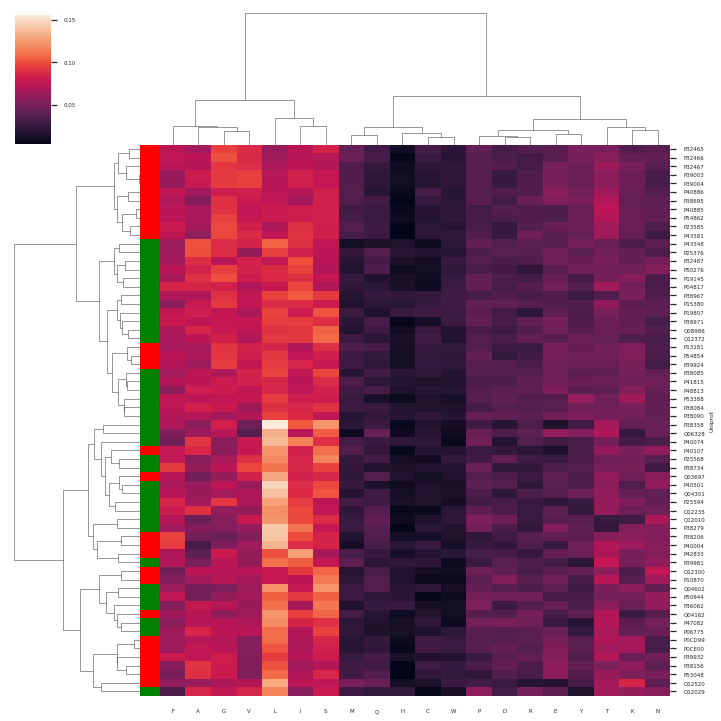

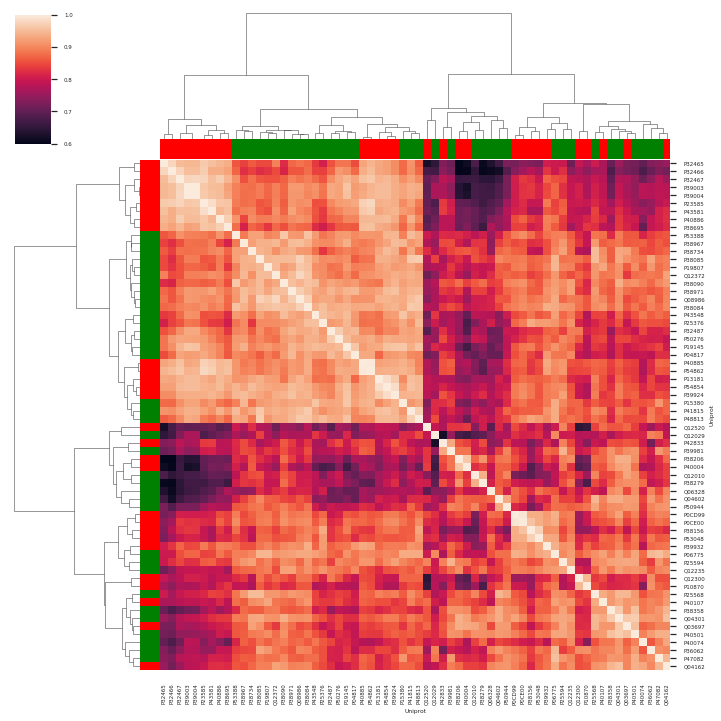

In [11]:
df_features = pd.read_table(f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0)
df_labels = pd.read_table(f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0)

labels_unique = df_labels.labels.unique()
colors = ["red", "green", "blue", "yellow", "magenta", "cyan", "black"]
colors_dict = {labels_unique[i]: colors[i] for i in range(len(labels_unique))}
print(colors_dict)
colors_labels = [colors_dict[label] for label in df_labels.labels]

sns.set(font_scale=0.5)
sns.clustermap(
    data=df_features,
    xticklabels=df_features.columns,
    # yticklabels=None,
    row_colors=colors_labels,
    method="ward",
)
sns.set(font_scale=1)
plt.show()

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

sns.set(font_scale=0.5)
sns.clustermap(
    data=df_features.T.corr(),
    xticklabels=df_features.index,
    yticklabels=df_features.index,
    row_colors=colors_labels,
    col_colors=colors_labels,
    method="ward",
)
sns.set(font_scale=1)
plt.show()

### What are the two clusters?

In [12]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)

agg.fit(df_features)

df_annotations_clustered = pd.DataFrame(index= df_features.index, data=agg.labels_, columns=["cluster"]).join(df_annotations)

display(df_annotations_clustered[df_annotations_clustered.cluster == 0].head())

display(df_annotations_clustered[df_annotations_clustered.cluster == 1].head())

,cluster,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,,
P0CD99,0,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P38206,0,Sugar transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,RFT1 YBL020W YBL0442,Oligosaccharide translocation protein RFT1 (Re...,2.A.66.3.1,559292,MAKKNSQLPSTSEQILERSTTGATFLMMGQLFTKLVTFILNNLLIR...
Q12300,0,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,RGT2 YDL138W D2160,High glucose sensor RGT2 (Low-affinity glucose...,2.A.1.1.19,559292,MNDSQNCLRQREENSHLNPGNDFGHHQGAECTINHNNMPHRNAYTE...
Q12010,0,Amino-acid transport,Membrane;Transmembrane,Transport,YPQ1 YOL092W O0929,Probable vacuolar amino acid transporter YPQ1 ...,2.A.43.2.3,559292,MQLVPLELNRSTLSGISGSISISCWIIVFVPQIYENFYRKSSDGLS...
Q03697,0,Sugar transport,Membrane;Transmembrane,Transport,YMD8 YML038C,Putative nucleotide-sugar transporter YMD8,2.A.7.9.14,559292,MNRTVFLAFVFGWYFCSIALSIYNRWMFDPKDGLGIGYPVLVTTFH...


,cluster,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,,
Q08986,1,Amino-acid transport,Endoplasmic reticulum;Membrane;Transmembrane,Transport,SAM3 YPL274W,S-adenosylmethionine permease SAM3 (S-adenosyl...,2.A.3.10.15,559292,MDILKRGNESDKFTKIETESTTIPNDSDRSGSLIRRMKDSFKQSNL...
P38967,1,Amino-acid transport,Membrane;Transmembrane,Transport,TAT2 LTG3 SAB2 SCM2 TAP2 YOL020W,Tryptophan permease (Tryptophan amino acid tra...,2.A.3.10.8,559292,MTEDFISSVKRSNEELKERKSNFGFVEYKSKQLTSSSSHNSNSSHH...
P39003,1,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P38085,1,Amino-acid transport,Membrane;Transmembrane,Transport,TAT1 TAP1 VAP1 YBR069C YBR0710,Valine/tyrosine/tryptophan amino-acid permease...,2.A.3.10.9,559292,MDDSVSFIAKEASPAQYSHSLHERTHSEKQKRDFTITEKQDEVSGQ...
P15380,1,Amino-acid transport,Membrane;Transmembrane,Transport,PUT4 YOR348C O6345,Proline-specific permease,2.A.3.10.3,559292,MVNILPFHKNNRHSAGVVTCADDVSGDGSGGDTKKEEDVVQVTESP...


### TCDB IDs in Datensatz

- Most are 2A
- Other ones also look okay

In [13]:
df_annotations.fillna("Nan").tcdb_id.apply(lambda s: s[0:7]).value_counts()

2.A.3.1    17
2.A.1.1    16
Nan         9
2.A.18.     6
2.A.43.     3
2.A.1.4     3
2.A.7.1     3
2.A.3.8     2
2.A.66.     1
2.A.7.9     1
2.A.1.2     1
2.A.3.4     1
2.A.54.     1
Name: tcdb_id, dtype: int64

In [14]:
df_annotations[df_annotations.tcdb_id.isnull()]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P39003,Sugar transport,Membrane;Transmembrane,Transport,HXT6 YDR343C D9651.12,High-affinity hexose transporter HXT6,NaN,559292,MSQDAAIAEQTPVEHLSAVDSASHSVLSTPSNKAERDEIKAYGEGE...
P40886,Sugar transport,Membrane;Transmembrane,Transport,HXT8 YJL214W HRA569 J0232,Hexose transporter HXT8,NaN,559292,MTDRKTNLPEEPIFEEAEDDGCPSIENSSHLSVPTVEENKDFSEYN...
P38156,Sugar transport,Membrane;Transmembrane,Transport,MAL31 MAL3T YBR298C YBR2116,Maltose permease MAL31 (Maltose transport prot...,NaN,559292,MKGLSSLINRKKDRNDSHLDEIENGVNATEFNSIEMEEQGKKSDFD...
P40885,Sugar transport,Membrane;Transmembrane,Transport,HXT9 YJL219W HRC567 J0222,Hexose transporter HXT9,NaN,559292,MSGVNNTSANDLSTTESNSNSVANAPSVKTEHNDSKNSLNLDATEP...
P0CE00,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH3 YJR160C J2400,Alpha-glucosides permease MPH3 (Maltose transp...,NaN,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...
P38695,Sugar transport,Membrane;Transmembrane,Transport,HXT5 YHR096C,Probable glucose transporter HXT5,NaN,559292,MSELENAHQGPLEGSATVSTNSNSYNEKSGNSTAPGTAGYNDNLAQ...
P32466,Sugar transport,Membrane;Transmembrane,Transport,HXT3 YDR345C D9651.14,Low-affinity glucose transporter HXT3,NaN,559292,MNSTPDLISPQKSSENSNADLPSNSSQVMNMPEEKGVQDDFQAEAD...
P25594,Amino-acid transport,Membrane;Transmembrane,Transport,VBA3 YCL069W YCL69W,Vacuolar basic amino acid transporter 3,NaN,559292,MNMLIVGRVVASVGGSGLQTLCFVIGCTMVGERSRPLVISILSCAF...


### 3.3 Korrelation der Features



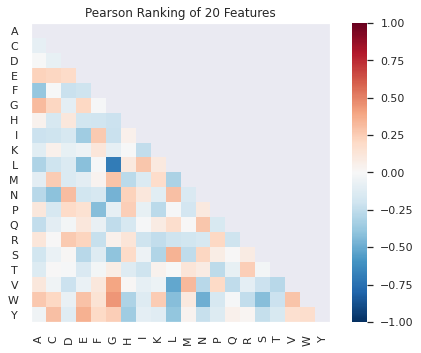

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [15]:
df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
r2d = Rank2D(algorithm="pearson")
r2d.fit_transform(df_aac, df_labels.labels)
r2d.show()

#### Nur AA transporter

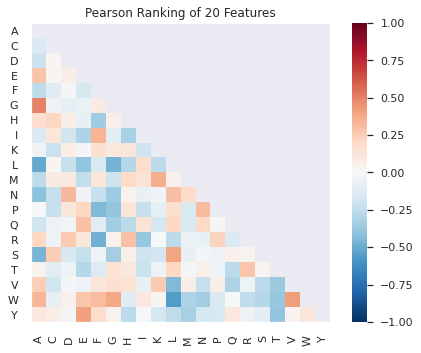

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [16]:
mask_amino = df_labels.labels == "Amino-acid transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_amino], df_labels.loc[mask_amino].labels)
r2d.show()

#### Nur Sugar transporter

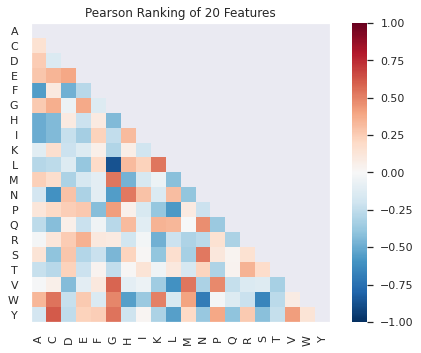

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [17]:
mask_sugar = df_labels.labels == "Sugar transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_sugar], df_labels.loc[mask_sugar].labels)
r2d.show()

### 3.4 Folgen die AAC Features einer Normalverteilung?


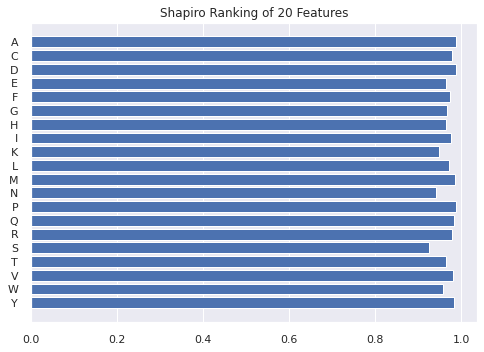

<AxesSubplot:title={'center':'Shapiro Ranking of 20 Features'}>

In [18]:
df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
r2d = Rank1D(algorithm="shapiro")
r2d.fit_transform(df_aac, df_labels.labels)
r2d.show()


#### Verteilung von S


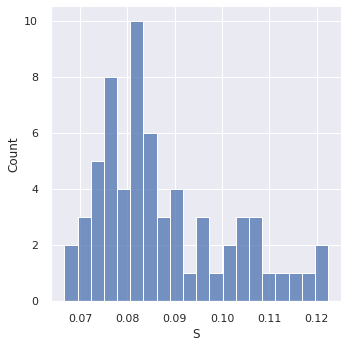

In [19]:
import seaborn as sns
sns.displot(df_aac.S, bins=20)

#### Proteine mit hohen D

- There seems to be one protein that does not fit in the normal distribution
- Again, it's the accessory factor RBAT

In [20]:
df_annotations.loc[df_aac[df_aac.S > 0.06].index].join(df_aac.S, how="left").drop("sequence", axis=1).sort_values("S", ascending=False)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,S
Uniprot,,,,,,,,
Q04602,Amino-acid transport,Membrane;Transmembrane,Transport,VBA4 YDR119W,Vacuolar basic amino acid transporter 4,2.A.1.48.5,559292,0.122396
P38358,Amino-acid transport,Membrane;Transmembrane,Transport,VBA2 YBR293W YBR2109,Vacuolar basic amino acid transporter 2,2.A.1.48.2,559292,0.122363
P25568,Amino-acid transport,Membrane;Transmembrane,Transport,ATG22 AUT4 YCL038C YCL38C,Autophagy-related protein 22,2.A.1.24.19.A.15.1.1,559292,0.117424
P10870,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SNF3 YDL194W D1234,Low glucose sensor SNF3 (High-affinity glucose...,2.A.1.1.17,559292,0.114253
P36062,Amino-acid transport,Membrane;Transmembrane,Transport,AVT3 YKL146W YKL600,Vacuolar amino acid transporter 3,2.A.18.7.1,559292,0.112717
...,...,...,...,...,...,...,...,...
P38156,Sugar transport,Membrane;Transmembrane,Transport,MAL31 MAL3T YBR298C YBR2116,Maltose permease MAL31 (Maltose transport prot...,NaN,559292,0.071661
P50276,Amino-acid transport,Membrane;Transmembrane,Transport,MUP1 YGR055W,High-affinity methionine permease,2.A.3.8.4,559292,0.069686
P04817,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,CAN1 YEL063C,Arginine permease CAN1 (Canavanine resistance ...,2.A.3.10.4,559292,0.069492


### 3.5 Feature importance


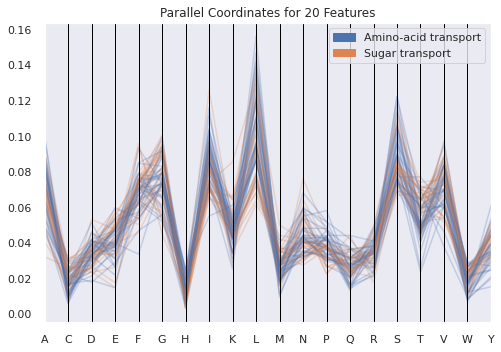

<AxesSubplot:>

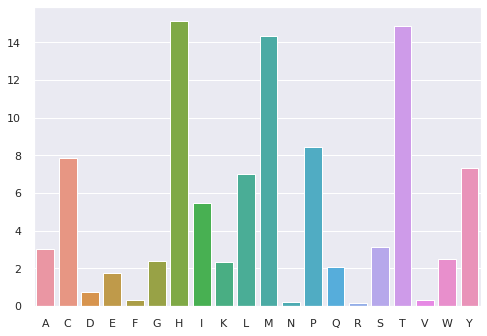

In [21]:
pc = ParallelCoordinates()

pc.fit_transform(df_aac, df_labels.labels)
pc.show()

skb = SelectKBest(k=20)
skb.fit(df_aac, df_labels.labels)
sns.barplot(x=df_aac.columns, y=skb.scores_)


### 3.6 Boxplots alle, amino, sugar

- Hier sieht man Unterschiede im Mittelwert bei den guten Features, allerdings auch Überschneidung
- Die guten Features zusammen könnten im 5-dimensionalen Raum für die guten SVM Ergebnisse sorgen.

<AxesSubplot:>

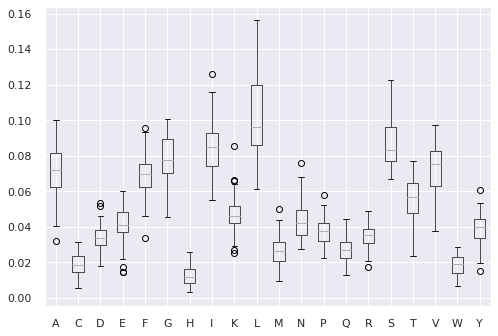

In [22]:
df_aac.boxplot()

<AxesSubplot:>

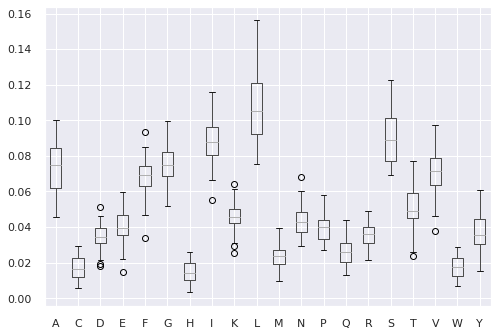

In [23]:
df_aac.loc[mask_amino].boxplot()

<AxesSubplot:>

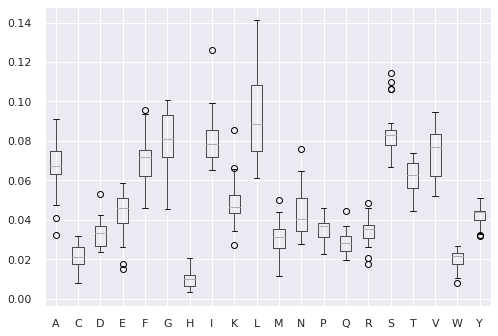

In [24]:
df_aac.loc[mask_sugar].boxplot()

### PCA Plots

Hier sind die PCA Plots, wegen denen ich die Analyse angefangen habe. Ich hatte mich gefragt, warum die SVM gut Ergebnisse liefert, obwohl der PCA plot so uneindeutig aussieht. 

Man sieht oben rechts wieder die Outliers mit hohem Prolin/Glutamat Anteil. 

**TODO sind das wirklich die gleichen?**

Bei dem 3D Plot sieht man, dass die Auftrennung schon etwas besser wird. 

Weiter unten wird sich zeigen, dass die lineare SVM erst im 3D Raum gute Scores liefert (f1>0.8).

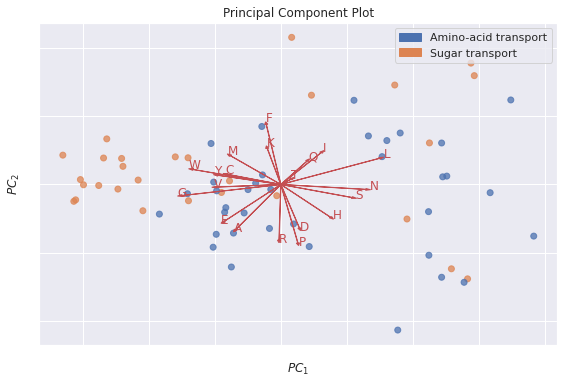

/home/ad/miniconda3/envs/subpred/lib/python3.9/site-packages/yellowbrick/features/pca.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


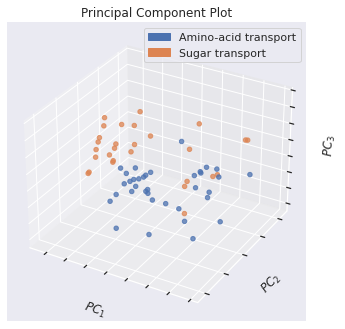

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [25]:
from yellowbrick.features import PCA as PCAPlot

df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
le = LabelEncoder()
y = le.fit_transform(df_labels.labels.ravel())

pca_plot = PCAPlot(classes=le.classes_, scale=True, proj_features=True, features=df_aac.columns)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

pca_plot = PCAPlot(classes=le.classes_, scale=True, features=df_aac.columns, projection=3)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

## Model training 

### Test: Does removing the outliers improve classification results?

- Yes, there is a small improvement

##### With outliers

In [26]:
create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "remove",
    verbose = True,
    tax_ids_filter = [TAX_ID],
    output_tsv = f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta = f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log = LOG_FILE,
)
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_labels.tsv"
)
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    feature_type="aac",
)

df_aac_outliers = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0
)
df_labels_outliers = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
print(df_labels_outliers.labels.value_counts())
X_outliers = df_aac_outliers.to_numpy()
label_encoder = LabelEncoder()
y_outliers = label_encoder.fit_transform(df_labels_outliers.to_numpy().ravel())

gsearch = GridSearchCV(
    estimator=make_pipeline(
        StandardScaler(),
        SVC(max_iter=1e6),
    ),
    param_grid={
        "svc__class_weight": ["balanced", None],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", 0.1, 0.01, 0.001],
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
)
gsearch.fit(X_outliers, y_outliers)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc = gsearch.best_estimator_


Amino-acid transport    36
Sugar transport         28
Name: labels, dtype: int64
{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.8984848484848484


# About the dataset

- No outliers found
- Two distinct clusters of same size
- Still very good performance